In [33]:
import json
import pandas as pd
import numpy as np
from typing import Any
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import cm

In [34]:
def parse_results(path: str) -> pd.DataFrame:
    records = []
    with open(path, 'r') as f:
        buffer = []
        depth = 0

        for raw in f:
            line = raw.strip()
            if not line:
                continue  # skip blank lines

            # Track nesting of braces
            depth += line.count('{')
            depth -= line.count('}')

            buffer.append(raw)
            # If we’ve closed all opened braces, process one full JSON object
            if depth == 0 and buffer:
                chunk = ''.join(buffer)
                obj = json.loads(chunk)
                # same flattening logic as before
                for uid, details in obj.items():
                    params = details.pop('params')
                    flat = {'id': uid, **details}
                    for p, v in params.items():
                        if isinstance(v, list) and len(v) == 2:
                            flat[f'{p}_x'] = v[0]
                            flat[f'{p}_y'] = v[1]
                        else:
                            flat[p] = v
                    records.append(flat)
                buffer = []
    return pd.DataFrame(records)

In [35]:
def get_config(file_path: str):
    stem = Path(file_path).stem            
    config_name = stem.removeprefix("result_")      
    
    config_path = Path("../configurations") / f"{config_name}.json"
    
    # 3) Open & load the JSON
    with config_path.open("r", encoding="utf-8") as f:
        config = json.load(f)
    return config

In [36]:
def collect_all_records(
    path,                # e.g. "results/"
    solver,              # substring to match in filename
    reconstruction_algo  # another substring to match
):
    path = Path(path)
    group = {}

    # 1) gather all matching files into `group[name] = df`
    for file_path in path.iterdir():
        if not file_path.is_file():
            continue
        name = file_path.name
        if solver in name and reconstruction_algo in name:
            # parse_results should return a DataFrame
            group[name] = parse_results(file_path)

    # 2) error if nothing matched
    if not group:
        raise Exception(
            f"No files found in {path!r} containing "
            f"{solver!r} AND {reconstruction_algo!r}"
        )

    # 3) build a config dict for each name
    config = { name: get_config(name) for name in group }

    # 4) for each df, attach all rows + filename + config
    all_slices = []
    for name, df in group.items():
        df_full = df.copy()

        # add a column so we know which file this row came from
        df_full['filename'] = name

        # grab the config dict for this experiment
        conf = config[name]
        # turn it into a DataFrame with same length, then concat
        conf_df = pd.DataFrame([conf] * len(df_full), index=df_full.index)

        merged = pd.concat([
            df_full.reset_index(drop=True),
            conf_df.reset_index(drop=True)
        ], axis=1)

        all_slices.append(merged)

    # 5) stitch everything together
    result = pd.concat(all_slices, ignore_index=True)
    return result

In [37]:
reconstruction_algo = "ST"
solver="GridSearch"

df_all_GS = collect_all_records("../results/", "GridSearch", reconstruction_algo)
df_all_PH =  collect_all_records("../results/", "PolyHoot", reconstruction_algo)
df_all_PSO = collect_all_records("../results/", "ParticleSwarm", reconstruction_algo)
df_all_B = collect_all_records("../results/", "Bayesian", reconstruction_algo)

In [38]:
import numpy as np
import matplotlib.pyplot as plt

def plot_pareto(
    df,
    x_param,
    y_param,
    annotate_cols=None,
    annotate_markers=None,
    col_labels=None,
    degree=1,
    figsize=(8, 5),
    marker='o',
    alpha=0.8,
    title_fontsize=18,
    label_fontsize=14,
    tick_fontsize=12,
    dpi=300,
    title="Pareto Scatter with Regression",
    XTitle=None,
    YTitle=None,
    pareto_color='C1',
    regression_color='red',
    regression_label=None,
    XMAX=100,
    YMAX=100,
    ax=None            # ← NEW
):
    """
    If `ax` is None, makes its own fig, ax. Otherwise draws into the provided ax.
    Returns (fig, ax).
    """
    annotate_cols    = annotate_cols    or []
    annotate_markers = annotate_markers or ['*']
    col_labels       = col_labels       or {}

    # Styling (only set once if creating new fig)
    if ax is None:
        # plt.rcParams.update({
        #     "font.family":       "serif",
        #     "font.serif":        ["Times New Roman","Palatino","serif"],
        #     "axes.titlesize":    title_fontsize,
        #     "axes.labelsize":    label_fontsize,
        #     "xtick.labelsize":   tick_fontsize,
        #     "ytick.labelsize":   tick_fontsize,
        #     "figure.dpi":        dpi,
        #     "axes.grid":         True,
        #     "grid.color":        "#999999",
        #     "grid.alpha":        0.2,
        #     "grid.linestyle":    "--"
        # })
        plt.rcParams.update({
                "figure.facecolor":   "#F6F6F6",  # <- Correct key with hex
                "axes.facecolor":     "#FFFFFF",  # <- Optional: set axes background
                "font.family":        "serif",
                "font.serif":         ["Times New Roman", "Palatino", "serif"],
                "axes.titlesize":     title_fontsize,
                "axes.labelsize":     label_fontsize,
                "xtick.labelsize":    tick_fontsize,
                "ytick.labelsize":    tick_fontsize,
                "figure.dpi":         dpi,
                "axes.linewidth":     1.0,
                "xtick.major.size":   5,
                "ytick.major.size":   5,
                "xtick.major.width":  0.8,
                "ytick.major.width":  0.8,
                "axes.grid":          True,
                "grid.color":         "#999999",
                "grid.alpha":         0.2,
                "grid.linestyle":     "--"
            })
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.figure

    # Extract data and Pareto front
    data = df[[x_param, y_param]].values
    sorted_idx = np.argsort(data[:, 0])
    pareto_front = []
    best_y = np.inf
    for idx in sorted_idx:
        x_val, y_val = data[idx]
        if y_val < best_y:
            pareto_front.append(idx)
            best_y = y_val
    pareto_idx = np.array(pareto_front, dtype=int)
    pf_x, pf_y = data[pareto_idx, 0], data[pareto_idx, 1]

    # Fit regression
    coeffs = np.polyfit(pf_x, pf_y, deg=degree)
    poly = np.poly1d(coeffs)

    # Best-sum point
    sum_series = df[x_param] + df[y_param]
    best_idx = sum_series.idxmin()
    x0, y0 = df.loc[best_idx, x_param], df.loc[best_idx, y_param]

    # Plot points & front
    print(f"{title} - {df.shape}")
    ax.scatter(df[x_param], df[y_param], marker=marker, alpha=alpha, label='Data points', color="#3D58DD")
    ax.plot(pf_x, pf_y, linestyle='--', color=pareto_color, label='Pareto front', alpha=0.7)

    # Annotate best-sum
    # sym = annotate_markers[0]
    # ax.annotate(sym, xy=(x0, y0), xytext=(-13, -13), textcoords='offset points',
    #             fontsize=label_fontsize-2, ha='left', va='bottom')

    # Info box
    # info_lines = [f"{sym}:"]
    # for col in annotate_cols:
    #     pretty = col_labels.get(col, col)
    #     info_lines.append(f"    {pretty}: {df.loc[best_idx, col]}")
    # info_text = "\n".join(info_lines)
    # fig.subplots_adjust(right=0.75)
    # ax.text(1.02, 0.5, info_text, transform=ax.transAxes,
    #         fontsize=label_fontsize-2, va='center', ha='left')

    # Final touches
    if XTitle != None:
        ax.set_xlabel(XTitle, fontweight='bold')
    if YTitle != None:
        ax.set_ylabel(YTitle, fontweight='bold')
    ax.set_title(title)
    ax.set_xlim(0, XMAX)
    ax.set_ylim(0, YMAX)
    ax.legend(loc='upper right')

    return fig, ax

In [39]:
annotate_cols=[
            "min_strong_track_length",
            "allowed_missed_modules",
            "scatter"
        ] #ST

col_labels = {
    'min_strong_track_length': r'$\ell_{\mathrm{strong}}^{\min}$',
    'allowed_missed_modules':   r'$n_{\mathrm{miss}}$',
    'scatter':                  r'$\sigma$'
}

PolyHoot - (10000, 18)
Particle Swarm - (9252, 18)
Grid Search - (13978, 18)
Bayesian - (756, 18)


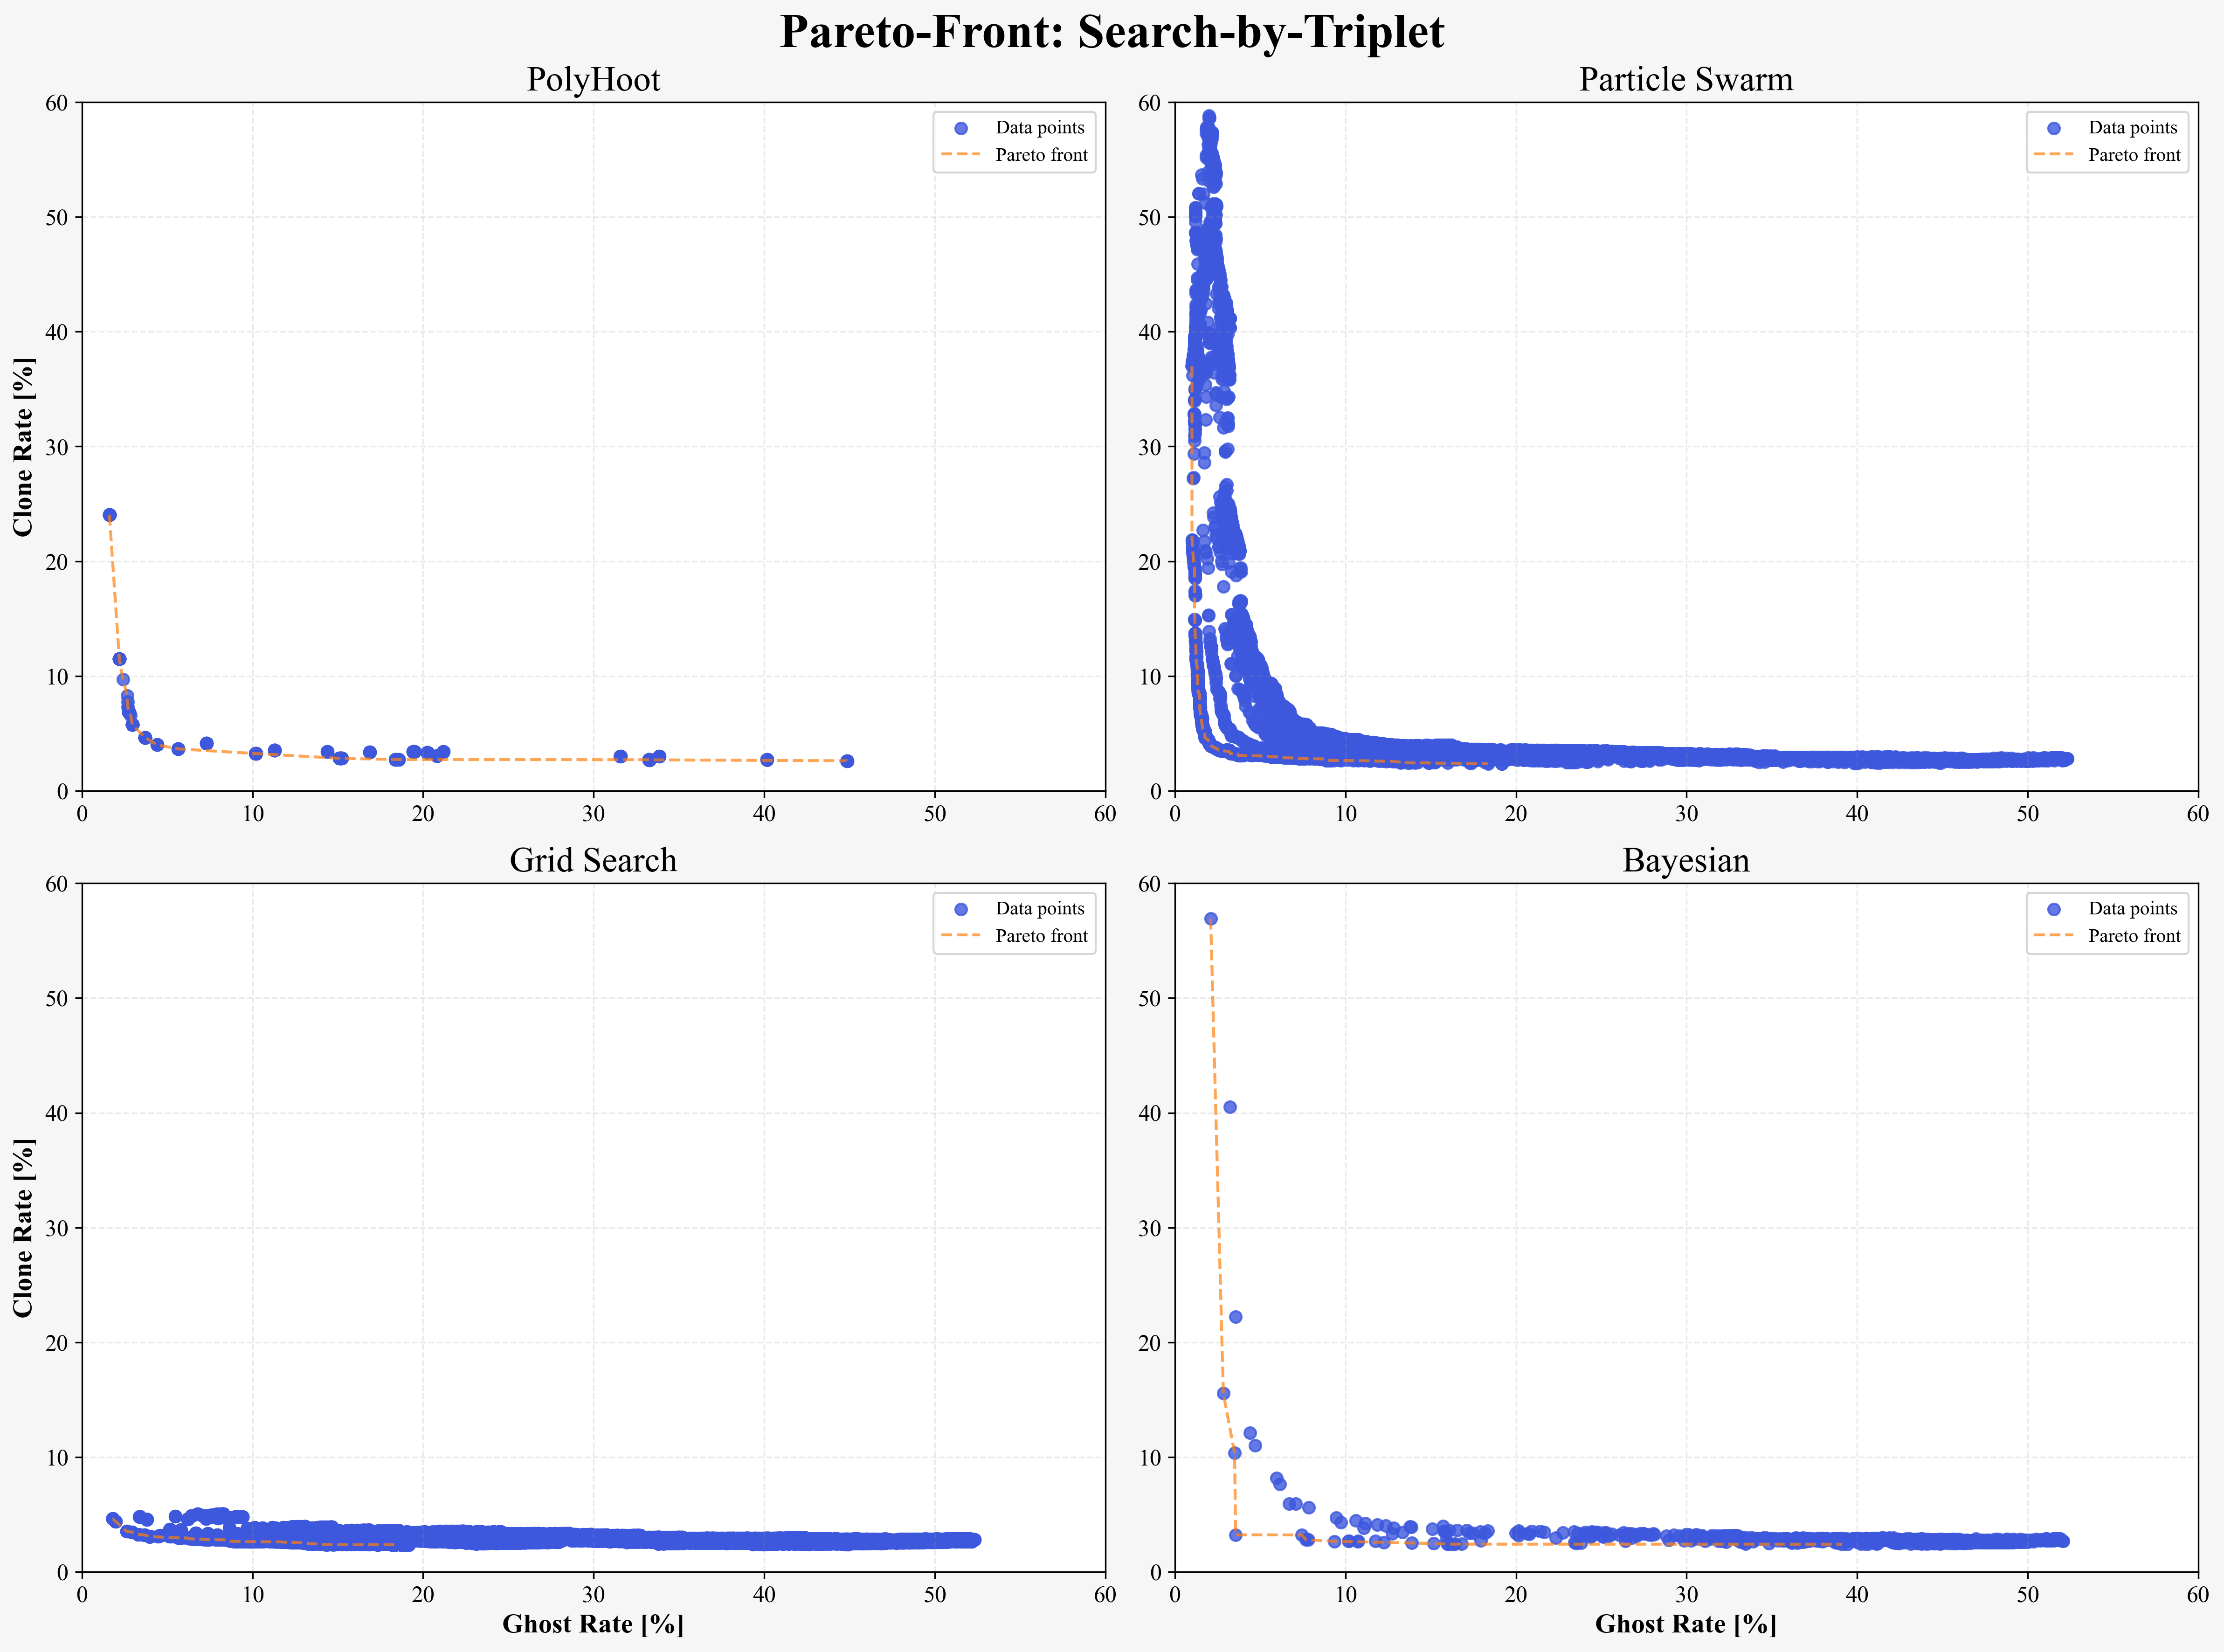

In [40]:
# Suppose you want four different parameter‐sets:
configs = [
    dict(title="PolyHoot", YTitle="Clone Rate [%]"),
    dict(title="Particle Swarm"),
    dict(title="Grid Search", XTitle="Ghost Rate [%]", YTitle="Clone Rate [%]"),
    dict(title="Bayesian", XTitle="Ghost Rate [%]"),
]

PSO = df_all_PSO[(df_all_PSO["event_avg_ghost_rate"] > 1) & (df_all_PSO["clone_percentage"] != 0)]
GS = df_all_GS[(df_all_GS["event_avg_ghost_rate"] > 1) & (df_all_GS["clone_percentage"] != 0)]
dfs = [df_all_PH, PSO, GS, df_all_B]

plt.rcParams.update({
    "figure.facecolor":   "#F6F6F6",  # <- Correct key with hex
    "axes.facecolor":     "#FFFFFF", 
        "font.family":       "serif",
        "font.serif":        ["Times New Roman","Palatino","serif"],
        "axes.titlesize":    18,
        "axes.labelsize":    14,
        "xtick.labelsize":   12,
        "ytick.labelsize":   12,
        "figure.dpi":        300,
        "axes.grid":         True,
        "grid.color":        "#999999",
        "grid.alpha":        0.2,
        "grid.linestyle":    "--"
    })


fig, axes = plt.subplots(2, 2, figsize=(16, 12), dpi=300)

for ax, df_, cfg in zip(axes.flatten(), dfs, configs):
    # pass through all your annotate_cols, etc. as needed
    plot_pareto(
        df = df_,
        x_param='event_avg_ghost_rate',
        y_param='clone_percentage',
        annotate_cols=annotate_cols,
        annotate_markers=['*'],
        col_labels=col_labels,
        degree=1,
        XMAX=60, YMAX=60,
        **cfg,
        ax=ax
    )

fig.suptitle("Pareto-Front: Search-by-Triplet", fontsize=25, fontweight='bold')
plt.tight_layout()
plt.show()


In [41]:
df_unique = df_all_PH.drop_duplicates(
    subset=['event_avg_ghost_rate', 'clone_percentage'],
    keep='first'   # or 'last'; default is 'first'
)
df_unique.shape

(254, 18)

In [42]:
max_value = df_all_PSO["clone_percentage"].max()
max_row = df_all_PSO[df_all_PSO["clone_percentage"] == max_value]
print(max_row)


                                         id         score  total_ghosts  \
12332  176b5ea7-25f7-494f-9d7e-c2689269cf53  14381.230508           705   

       overall_ghost_rate  event_avg_ghost_rate  clone_percentage  \
12332            2.451321              2.009611         58.828635   

       total_tracks     time   scatter  min_strong_track_length  \
12332         28760  0.48474  0.000775                      2.0   

       allowed_missed_modules  \
12332                     2.0   

                                                filename     solverName  \
12332  result_ParticleSwarm_ST_3_a1b0e845-fa80-4f77-9...  ParticleSwarm   

      reconstruction_algo  num_events  intra_node  max_runs  \
12332                  ST         100        True      1000   

                                               optimizer  
12332  {'inertia': 0.5, 'cognitive': 1.5, 'social': 1...  


In [43]:
# print(df_all_GS[df_all_GS["scatter"] == 0.000775])


In [44]:
target = 0.000775
closest_row = df_all_GS.loc[(df_all_GS["scatter"] - target).abs().idxmin()]
print(closest_row)


id                                      53f70ab0-d050-41f7-9417-53d26bd285c7
score                                                          999999.258133
total_ghosts                                                               0
overall_ghost_rate                                                       0.0
event_avg_ghost_rate                                                     0.0
clone_percentage                                                         0.0
total_tracks                                                               0
time                                                                0.645331
scatter                                                                  0.0
min_strong_track_length                                                  1.0
allowed_missed_modules                                                   1.0
filename                              result_GridSearch_ST_1_extensive.jsonl
solverName                                                        GridSearch